## Goal
Here, we will use RESNET34 architecture to train a classification model to identify the age range of images.

Age range definition based on Health Promotion Board of Singapore
- (A0) Young Children: 0-6 years 
- (A1) Children and Youth: 7-17 years 
- (A2) Youth Adults: 18-25 years
- (A3) Adults: 26-49 years
- (A4) Older adults: 50 years

The training data used is from UTKFace. We will use In-the-wild dataset since it contains most data, and we have a face crop engine ready.
Link: https://susanqq.github.io/UTKFace/

## Data

In [1]:
import os
os.getcwd()

'/home/Oak/fd_widerface_yolov8'

In [2]:
!gsutil ls gs://oak_datastorage

gs://oak_datastorage/utkface_dataset.zip
gs://oak_datastorage/yolov8-face-20epoch.pt


In [5]:
!gsutil cp gs://oak_datastorage/utkface_dataset.zip datasets/

Copying gs://oak_datastorage/utkface_dataset.zip...
- [1 files][  1.3 GiB/  1.3 GiB]   60.2 MiB/s                                   
Operation completed over 1 objects/1.3 GiB.                                      


In [9]:
# Commented out since the action has been done and we would not want to overwhelm the jupyter lab with lengthy feedback print
# !unzip datasets/utkface_dataset.zip -d datasets/

In [3]:
imglist = os.listdir("datasets/utkface_dataset")
print("Total number of images available:", len(imglist))
print("Example directory:", imglist[0])

Total number of images available: 24109
Example directory: 58_0_0_20170120222516888.jpg


The format of each data image is \<age>_\<gender>_\<race>_\<datetime>.jpg.

Since we are trying to develop an age classification model, let us leave out all the other information and extract out only the age.

## Face Extraction

Let us extract out faces from each frame for us to do age classification. By extracting out faces, the classifier can only look at facial information. The rationale for the focus on the face is to remove model biases that could originate from other potentially misleading information, such as clothing. 

We will extract the faces into a seperate folder, after which we would reorganize the data randomly into train, test and validation folder structure.

We will drop those images where duplicate faces are detected (<5% of the whole dataset) to avoid misleading the model, as we are not 100% sure the label is for which face.

In [77]:
# Since we have 5 age ranges, this means we have 5 labels. We will incorperate this into the cropped file names
def labelling(cropstr):
    age = int(cropstr.split("_")[0])
    if age<=6:
        agestr = "A0"
    elif age<=17:
        agestr = "A1"
    elif age<=25:
        agestr = "A2"
    elif age<=49:
        agestr = "A3"
    else:
        agestr = "A4"
    return agestr
    

In [78]:
import math
import cv2

save_directory = "datasets/cropped_utkface/"
classNames = ["face"]

def cropimgs(results, save_directory, expand_ratio = 0.2, CI = 0.7):
    # results: list of results for all the images after running the model
    # save_directory: location of output directory
    # expand_ratio: expand the size of x1,x2 by expand_ratio percent. 
    # CI: confidence interval of prediction. Only crop the image if the confidence is higher than this threshold
    
    count = 0
    dup_count = 0
    
    for r in results:
        boxes = r.boxes
        imgpath = r.path
        img = cv2.imread(imgpath)
        
        cropstr = imgpath.split("/")[-1].split(".jpg")[0]
        agestr = labelling(cropstr)
        
        img_index = 0
        
        # In this module, we remove duplicate
        if len(boxes)>1:
            # print("More than one face detected!")
            dup_count += 1
            continue

        for box in boxes:
            # bounding box
            x1, y1, x2, y2 = box.xyxy[0]
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2) # convert to int values
            
            # Calculate expanded coordinates
            x1 = max(0, int(x1 - expand_ratio * (x2 - x1)))
            y1 = max(0, int(y1 - expand_ratio * (y2 - y1)))
            x2 = min(img.shape[1], int(x2 + expand_ratio * (x2 - x1)))
            y2 = min(img.shape[0], int(y2 + expand_ratio * (y2 - y1)))

            # put box in cam
            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 255), 3)

            # confidence
            confidence = math.ceil((box.conf[0]*100))/100
            # print("Confidence --->",confidence)

            # # class name
            cls = int(box.cls[0])
            # print("Class name -->", classNames[cls])

            if classNames[cls] == "face" and confidence > CI:
                # Crop the person from the image
                cropped_person = img[y1:y2, x1:x2]

                # Save the cropped person image
                filename = f"{save_directory}{cropstr}_{agestr}.jpg"
                cv2.imwrite(filename, cropped_person)
                # img_index += 1
                
#                 if img_index > 1:
#                     print("Possible duplicate faces at", filename)
                
        count += 1
        
        if count%1000 == 0:
            print("Success count:", count)
            print("Duplicate count:", dup_count)


In [79]:
# Create directory first if it does not exist
if not os.path.exists(save_directory):
    os.makedirs(save_directory)
    print(f"Directory '{save_directory}' created.")
else:
    print(f"Directory '{save_directory}' already exists.")

Directory 'datasets/cropped_utkface/' created.


In [80]:
# Download the best available face detection model
from ultralytics import YOLO
model = YOLO('model/best.pt')
img_dir = "/home/jupyter/fd_widerface_yolov8/datasets/utkface_dataset/"
model.info()


Model summary: 225 layers, 3011043 parameters, 0 gradients, 8.2 GFLOPs


(225, 3011043, 0, 8.1941504)

In [81]:
# We will use generator for prediction to prevent overwhelming the CPU:
results = model(img_dir, stream=True, verbose=False);
print("Done creating generator")

Done creating generator


In [82]:
# Process results generator
cropimgs(results, save_directory)

Success count: 1000
Duplicate count: 39


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code


Success count: 2000
Duplicate count: 71
Success count: 3000
Duplicate count: 124
Success count: 4000
Duplicate count: 163
Success count: 5000
Duplicate count: 219
Success count: 6000
Duplicate count: 298
Success count: 7000
Duplicate count: 342
Success count: 8000
Duplicate count: 376
Success count: 9000
Duplicate count: 408
Success count: 10000
Duplicate count: 450
Success count: 11000
Duplicate count: 486
Success count: 12000
Duplicate count: 534
Success count: 13000
Duplicate count: 573
Success count: 14000
Duplicate count: 605
Success count: 15000
Duplicate count: 644
Success count: 16000
Duplicate count: 677
Success count: 17000
Duplicate count: 714
Success count: 18000
Duplicate count: 749
Success count: 19000
Duplicate count: 787
Success count: 20000
Duplicate count: 837


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


Success count: 21000
Duplicate count: 880
Success count: 22000
Duplicate count: 928
Success count: 23000
Duplicate count: 973


### Generation of dataset

Here, we will generate folders for datasets and move our data there.

In [84]:
# Since we have 5 age ranges, this means we have 5 labels.

# Creating relevant directory
train_dir = "datasets/labcrop_utkface/train"
val_dir = "datasets/labcrop_utkface/val"
test_dir = "datasets/labcrop_utkface/test"
dirlist = [train_dir, val_dir, test_dir]
lablist = ["/A0", "/A1", "/A2", "/A3", "/A4"]

for datadir in dirlist:
    for labdir in lablist:
        directory = datadir+labdir    
        if not os.path.exists(directory):
            os.makedirs(directory)
            print(f"Directory '{directory}' created.")
        else:
            print(f"Directory '{directory}' already exists.")


Directory 'datasets/labcrop_utkface/train/A0' created.
Directory 'datasets/labcrop_utkface/train/A1' created.
Directory 'datasets/labcrop_utkface/train/A2' created.
Directory 'datasets/labcrop_utkface/train/A3' created.
Directory 'datasets/labcrop_utkface/train/A4' created.
Directory 'datasets/labcrop_utkface/val/A0' created.
Directory 'datasets/labcrop_utkface/val/A1' created.
Directory 'datasets/labcrop_utkface/val/A2' created.
Directory 'datasets/labcrop_utkface/val/A3' created.
Directory 'datasets/labcrop_utkface/val/A4' created.
Directory 'datasets/labcrop_utkface/test/A0' created.
Directory 'datasets/labcrop_utkface/test/A1' created.
Directory 'datasets/labcrop_utkface/test/A2' created.
Directory 'datasets/labcrop_utkface/test/A3' created.
Directory 'datasets/labcrop_utkface/test/A4' created.


In [98]:
source_folder = "datasets/cropped_utkface/"
allimages = os.listdir(source_folder)
print(len(allimages))

23056


In [99]:
import random

def split_data(data, train_percent=0.8, validation_percent=0.1, test_percent=0.1):
    total_size = len(data)
    train_size = int(total_size * train_percent)
    validation_size = int(total_size * validation_percent)
    
    # Ensure that the sizes add up to the total size
    test_size = total_size - train_size - validation_size
    
    # Shuffle the data randomly
    random.shuffle(data)
    
    # Split the data into three sets
    train_data = data[:train_size]
    validation_data = data[train_size:train_size + validation_size]
    test_data = data[train_size + validation_size:]
    
    return train_data, validation_data, test_data


In [100]:
train_data, val_data, test_data = split_data(allimages)
print(len(train_data), len(val_data), len(test_data))

18444 2305 2307


In [101]:
train_data[0]

'28_0_0_20170117121808358_A3.jpg'

In [4]:
import shutil

def copy_file(source_path, destination_path):
    try:
        shutil.copy(source_path, destination_path)
        # print(f"File copied successfully from {source_path} to {destination_path}")
    except FileNotFoundError:
        print(f"Source file not found: {source_path}")
    except PermissionError:
        print(f"Permission error. Make sure you have the necessary permissions.")
    except Exception as e:
        print(f"An error occurred: {e}")

In [105]:
train_savedir = "datasets/labcrop_utkface/train/"

def assign_folders(savedir, data):
    source_path = source_folder+data
    label = data.split("_")[-1].split(".jpg")[0]
    cpdir = savedir+label
    copy_file(source_path,cpdir)
    
    
for item in train_data:
    assign_folders(train_savedir, item)
    

An error occurred: [Errno 21] Is a directory: 'datasets/cropped_utkface/.ipynb_checkpoints'


In [106]:
val_savedir = "datasets/labcrop_utkface/val/"
for item in val_data:
    assign_folders(val_savedir, item)

In [107]:
test_savedir = "datasets/labcrop_utkface/test/"
for item in test_data:
    assign_folders(test_savedir, item)
    

## Model Training

We will use RESNET34 architecture as the base for fine tuning. We can try finetune the whole model without freezing specific layers first. 

In [7]:
import numpy as np
import pandas as pd
from collections import OrderedDict
import torch
from torch import nn, optim
from torchvision import datasets, transforms, utils, models
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image
import torchvision
from torchsummary import summary

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device.type}")

Using device: cuda


In [9]:
train_dir = "datasets/labcrop_utkface/train"
val_dir = "datasets/labcrop_utkface/val"
test_dir = "datasets/labcrop_utkface/test"

In [11]:
IMAGE_SIZE = (200, 200)
BATCH_SIZE = 64

data_transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor()
])

train_dataset = torchvision.datasets.ImageFolder(root=train_dir, transform=data_transforms)
valid_dataset = torchvision.datasets.ImageFolder(root=val_dir, transform=data_transforms)

print("Class count for train dataset")
print(f"Classes: {train_dataset.classes}")
print(f"Class count: {train_dataset.targets.count(0)}, {train_dataset.targets.count(1)}, {train_dataset.targets.count(2)}, {train_dataset.targets.count(3)}, {train_dataset.targets.count(4)}")
print(f"Samples:",len(train_dataset))
print(f"First sample: {train_dataset.samples[0]}")

Class count for train dataset
Classes: ['A0', 'A1', 'A2', 'A3', 'A4']
Class count: 2092, 1357, 2634, 8563, 3797
Samples: 18443
First sample: ('datasets/labcrop_utkface/train/A0/1_0_0_20161219140623097_A0.jpg', 0)


In [12]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,          # our raw data
    batch_size=BATCH_SIZE,  # the size of batches we want the dataloader to return
    shuffle=True,           # shuffle our data before batching
    drop_last=False         # don't drop the last batch even if it's smaller than batch_size
)

valid_loader = torch.utils.data.DataLoader(
    valid_dataset,          # our raw data
    batch_size=BATCH_SIZE,  # the size of batches we want the dataloader to return
    shuffle=True,           # shuffle our data before batching
    drop_last=False         # don't drop the last batch even if it's smaller than batch_size
)

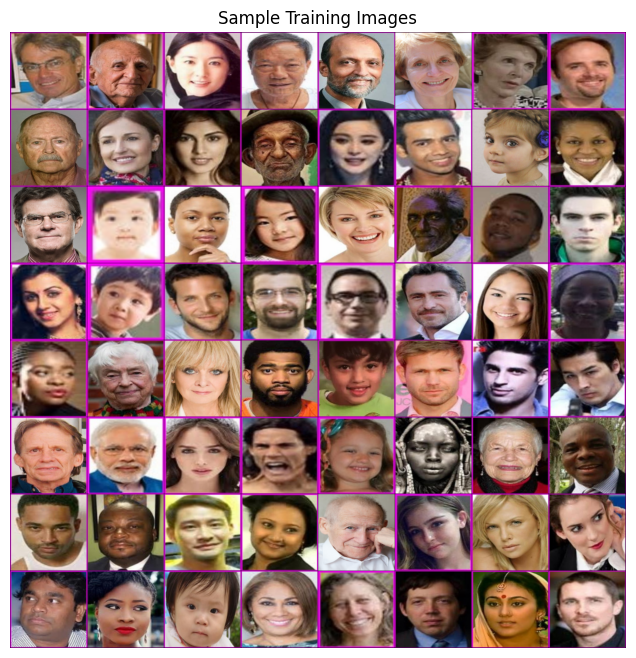

In [13]:
# Plot samples
sample_batch = next(iter(train_loader))
plt.figure(figsize=(10, 8)); plt.axis("off"); plt.title("Sample Training Images")
plt.imshow(np.transpose(utils.make_grid(sample_batch[0], padding=1, normalize=True),(1, 2, 0)));

In [14]:
model_resnet34 = models.resnet34(weights='ResNet34_Weights.DEFAULT')
model_resnet34.to(device)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /home/Oak/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|███████████████████████████████████████| 83.3M/83.3M [00:00<00:00, 160MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [15]:
# Replace the classification layer

new_layers = nn.Sequential(
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Linear(128, 5)
)

model_resnet34.fc = new_layers
model_resnet34.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
# Credit code inspired from DSCI572 from UBC MDS Program

def trainer(model, criterion, optimizer, trainloader, validloader, epochs=5, patience=5, checkpoint_dir='checkpoints', verbose=True):
    """Simple training wrapper for PyTorch network."""
    
    train_loss = []
    valid_loss = []
    train_accuracy = []
    valid_accuracy = []
    consec_increases = 0
    
    for epoch in range(epochs):  # for each epoch
        model.train()  # set the model to training mode
        
        train_batch_loss = 0
        train_batch_acc = 0
        valid_batch_loss = 0
        valid_batch_acc = 0
        
        # Training
        for X, y in trainloader:
            X=X.to(device)
            y=y.to(device)
            
            optimizer.zero_grad()                            # Zero all the gradients w.r.t. parameters
            outputs = model(X)
            y_hat = nn.functional.softmax(outputs, dim=1)  # This is to calculate the losses. 
            y_hat_labels = torch.argmax(y_hat, dim=1)

            loss = criterion(outputs, y)   # Calculate loss based on output            
            loss.backward()                                  # Calculate gradients w.r.t. parameters
            optimizer.step()                                 # Update parameters

            train_batch_loss += loss.item()                  # Add loss for this batch to running total
            train_batch_acc += (y_hat_labels == y).type(torch.float32).mean().item()   # Average accuracy for this batch
            
            # print("Done with a batch, train batch accuracy is:", train_batch_acc)
            
        train_loss.append(train_batch_loss / len(trainloader))     # loss = total loss in epoch / number of batches = loss per batch
        train_accuracy.append(train_batch_acc / len(trainloader))  # accuracy
        
        # Validation
        model.eval()  # this turns off those random dropout layers, we don't want them for validation!
        
        with torch.no_grad():  # this stops pytorch doing computational graph stuff under-the-hood and saves memory and time

            for X, y in validloader: 
                X=X.to(device)
                y=y.to(device)               
                outputs = model(X)
                y_hat = nn.functional.softmax(outputs, dim=1)  # This is to calculate the losses. 
                y_hat_labels = torch.argmax(y_hat, dim=1)
                loss = criterion(outputs, y)   # Calculate loss based on output            
                valid_batch_loss += loss.item()                  # Add loss for this batch to running total
                valid_batch_acc += (y_hat_labels == y).type(torch.float32).mean().item()   # Average accuracy for this batch
                
        valid_loss.append(valid_batch_loss / len(validloader))
        valid_accuracy.append(valid_batch_acc / len(validloader))  # accuracy
        
        model.train()  # turn back on the dropout layers for the next training loop
        
        # Print progress
        if verbose:
            print(f"Epoch {epoch + 1:3}:",
                  f"Train Loss: {train_loss[-1]:.3f}.",
                  f"Valid Loss: {valid_loss[-1]:.3f}.",
                  f"Train Accuracy: {train_accuracy[-1]:.2f}.",
                  f"Valid Accuracy: {valid_accuracy[-1]:.2f}.")
            
        # Save model checkpoint for each epoch
        checkpoint_path = os.path.join(checkpoint_dir, f'model_epoch_{epoch + 1}.pth')
        torch.save(model.state_dict(), checkpoint_path)
        
        # Early stopping
        if epoch > 0 and valid_loss[-1] > valid_loss[-2]:
            consec_increases += 1
        else:
            consec_increases = 0
        if consec_increases == patience:
            print(f"Stopped early at epoch {epoch + 1:3}: val loss increased for {consec_increases} consecutive epochs!")
            break
    
    results = {"train_loss": train_loss,
               "valid_loss": valid_loss,
               "train_accuracy": train_accuracy,
               "valid_accuracy": valid_accuracy}
    return results

In [164]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_resnet34.parameters(), lr=0.001)

results = trainer(model_resnet34, criterion, optimizer, train_loader, valid_loader, checkpoint_dir="runs/cls/run1", epochs=10)

Epoch   1: Train Loss: 0.783. Valid Loss: 0.781. Train Accuracy: 0.68. Valid Accuracy: 0.71.
Epoch   2: Train Loss: 0.637. Valid Loss: 0.710. Train Accuracy: 0.74. Valid Accuracy: 0.70.
Epoch   3: Train Loss: 0.586. Valid Loss: 0.618. Train Accuracy: 0.76. Valid Accuracy: 0.73.
Epoch   4: Train Loss: 0.531. Valid Loss: 0.643. Train Accuracy: 0.78. Valid Accuracy: 0.73.
Epoch   5: Train Loss: 0.489. Valid Loss: 0.660. Train Accuracy: 0.80. Valid Accuracy: 0.73.
Epoch   6: Train Loss: 0.418. Valid Loss: 0.752. Train Accuracy: 0.83. Valid Accuracy: 0.73.
Epoch   7: Train Loss: 0.352. Valid Loss: 0.998. Train Accuracy: 0.86. Valid Accuracy: 0.71.
Epoch   8: Train Loss: 0.285. Valid Loss: 0.786. Train Accuracy: 0.88. Valid Accuracy: 0.74.
Epoch   9: Train Loss: 0.232. Valid Loss: 0.848. Train Accuracy: 0.91. Valid Accuracy: 0.72.
Epoch  10: Train Loss: 0.187. Valid Loss: 0.967. Train Accuracy: 0.93. Valid Accuracy: 0.75.


There are signs of overfitting based on the validation loss. Let us try retraining the model with just the last few layers.

## Conducting Eye Test on Test Dataset

In [17]:
model_checkpoint_path = 'runs/fd_age/cls/run1/model_epoch_10.pth'
model_resnet34.load_state_dict(torch.load(model_checkpoint_path,  map_location=device))
model_resnet34.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [39]:
# Limit the number of images to process

BATCH_SIZE = 16

test_dataset = torchvision.datasets.ImageFolder(root=test_dir, transform=data_transforms)
test_loader = torch.utils.data.DataLoader(
    test_dataset,          # our raw data
    batch_size=BATCH_SIZE,  # the size of batches we want the dataloader to return
    shuffle=True,           # shuffle our data before batching
    drop_last=False         # don't drop the last batch even if it's smaller than batch_size
)

Batch_to_process = 1

def test_model(model, Batch_to_process, test_loader, visualize = False, visualize_freq = 100):
    
    y_list = []
    y_hat_list = []
    image_counter = 0
    
    # Iterate over batches in the test loader
    with torch.no_grad():  # this stops pytorch doing computational graph stuff under-the-hood and saves memory and time
        for X, y in test_loader: 
            X=X.to(device)
            y=y.to(device)               
            outputs = model(X)
            y_hat = nn.functional.softmax(outputs, dim=1)  # This is to calculate the losses. 
            y_hat_labels = torch.argmax(y_hat, dim=1)

            for i in range(len(y_hat_labels)):
                y_list.append(y[i].cpu()) 
                y_hat_list.append(y_hat_labels[i].cpu())
                image_counter += 1
                
                if visualize:
                    if image_counter%visualize_freq == 0:
                        # Visualize one image per frequency
                        sample_image = X[i].cpu().numpy().transpose((1, 2, 0))
                        sample_image = (sample_image * 0.5) + 0.5  # Denormalize
                        plt.figure(figsize=(3, 3))
                        plt.imshow(sample_image)
                        plt.title(f'Truth: {y[i].item()} | Prediction: {y_hat_labels[i].item()}')
                        plt.show()
                
                if image_counter%100 == 0:
                    print("Done prediction with", image_counter)
                        
                
        return y_list, y_hat_list

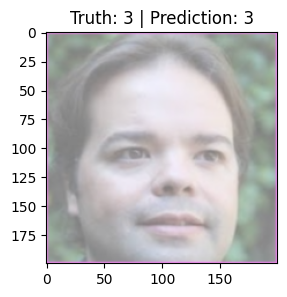

Done prediction with 100


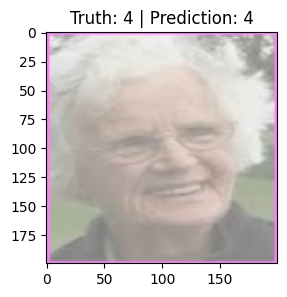

Done prediction with 200


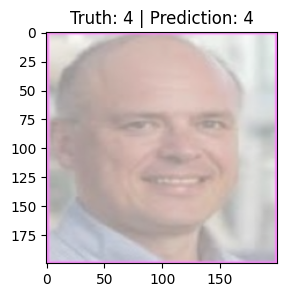

Done prediction with 300


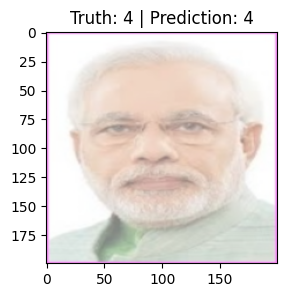

Done prediction with 400


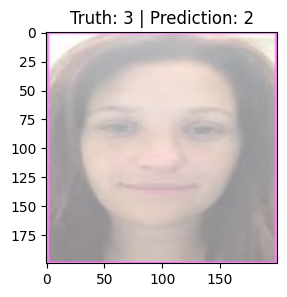

Done prediction with 500


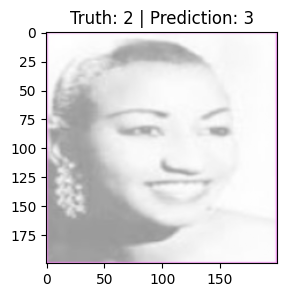

Done prediction with 600


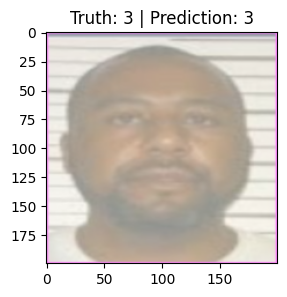

Done prediction with 700


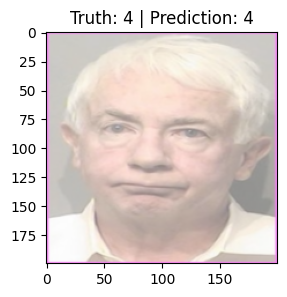

Done prediction with 800


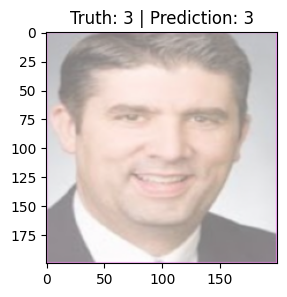

Done prediction with 900


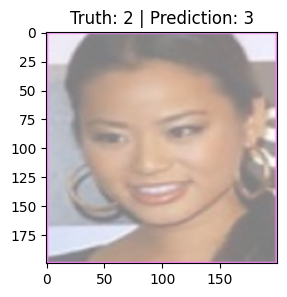

Done prediction with 1000


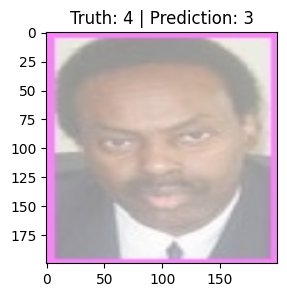

Done prediction with 1100


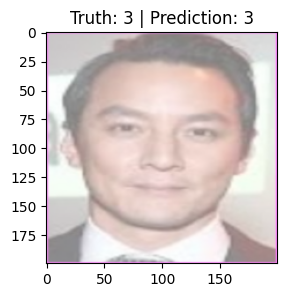

Done prediction with 1200


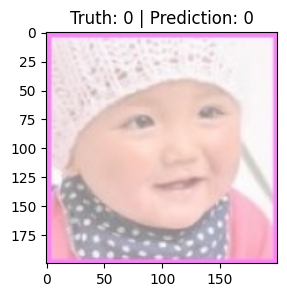

Done prediction with 1300


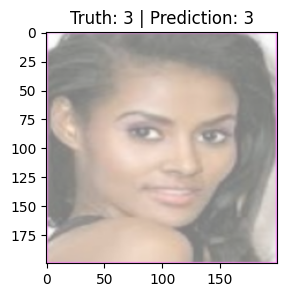

Done prediction with 1400


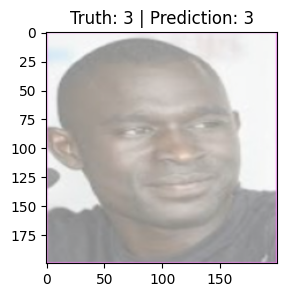

Done prediction with 1500


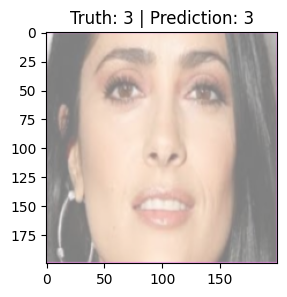

Done prediction with 1600


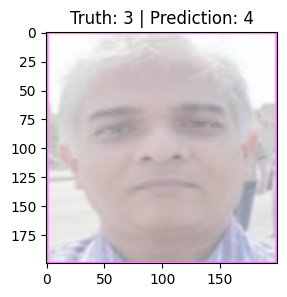

Done prediction with 1700


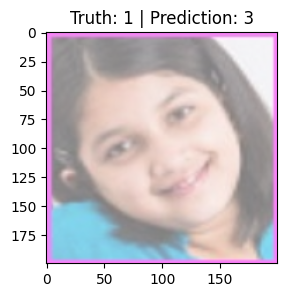

Done prediction with 1800


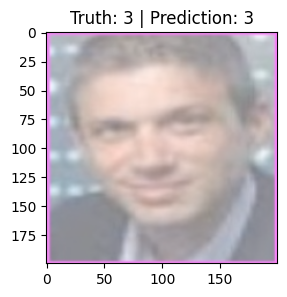

Done prediction with 1900


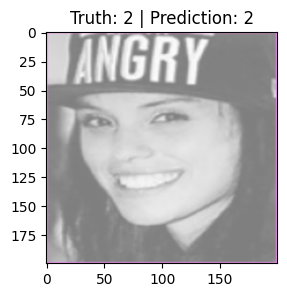

Done prediction with 2000


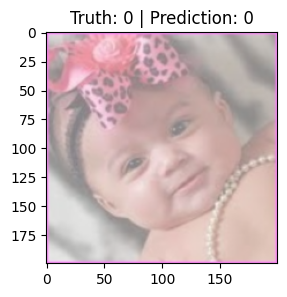

Done prediction with 2100


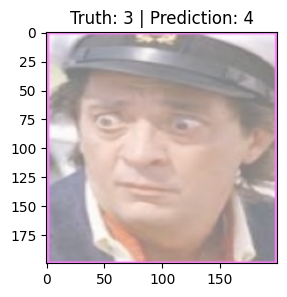

Done prediction with 2200


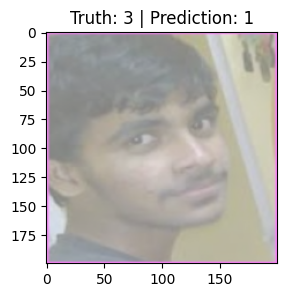

Done prediction with 2300


In [40]:
y, y_hat = test_model(model_resnet34, Batch_to_process, test_loader, visualize=True)

Not too bad for a model trainded to just 10 epochs. Let us show the confusion matrix on test dataset.

## Confusion Matrix

In [50]:
labels = ['Young Children','Children and Youth','Young Adults', 'Adults', 'Older Adults']

In [51]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, y_hat)
cm_df = pd.DataFrame(cm,
                     index = labels, 
                     columns = labels)

In [52]:
cm_df

,Young Children,Children and Youth,Young Adults,Adults,Older Adults
Young Children,198,28,1,0,1
Children and Youth,17,124,13,30,3
Young Adults,0,23,76,209,6
Adults,0,10,46,835,146
Older Adults,0,2,0,65,474


In [57]:
from sklearn.metrics import classification_report
print(classification_report(y, y_hat, target_names=labels))

                    precision    recall  f1-score   support

    Young Children       0.92      0.87      0.89       228
Children and Youth       0.66      0.66      0.66       187
      Young Adults       0.56      0.24      0.34       314
            Adults       0.73      0.81      0.77      1037
      Older Adults       0.75      0.88      0.81       541

          accuracy                           0.74      2307
         macro avg       0.73      0.69      0.69      2307
      weighted avg       0.73      0.74      0.72      2307

